In [50]:
from dataclasses import dataclass
import time
from tqdm import tqdm
from multiprocessing import Pool
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FuncFormatter
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import obspy as op
from obspy import read,read_inventory, UTCDateTime, Stream, Trace
from obspy.clients.fdsn.client import Client
from obspy.signal.rotate import rotate_ne_rt
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel

import json
import glob
import os
import numpy as np
from itertools import combinations
import pandas as pd
from scipy.signal import spectrogram, detrend, resample,savgol_filter,decimate,hilbert
from scipy.stats import circmean, circstd

import pyarrow.feather as feather
import seaborn as sns

import datetime

from sklearn.linear_model import LinearRegression,HuberRegressor,TheilSenRegressor

In [67]:
# ===========
# DIRECTORIES
# ===========

## ------------------------
## Directory of the catalog (.CSV file of the National Earthquake Information Center (NEIC))
## The file layout is defined as:
## time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource

XML_DIR = '/home/sysop/dados_posdoc/PROJETO_RSBR_15_YEARS/XML/'

## -----------------------
## Directory of the output (Figures and Feathers file)

ORIENTATION_OUTPUT = '/home/sysop/dados_posdoc/PROJETO_RSBR_15_YEARS/OUTPUT/'

# ==========
# PARAMETERS
# ==========

## -------------------------------------------------------------------
## Apply band-pass filtering to the seismograms using the range above:

PERIOD_BANDS = [0.02,0.5]

## ===================================================================================
## Default parameters to define the signal and noise windows used to estimate the SNR:

## ------------------------------------------------------------------------------
## Duration of the signal window before and after the P-wave arrival (in seconds)

TIME_WINDOW = 60

## -----------------------------------------------------------------------------
## Start time of the P-wave window for events (in seconds before P-wave arrival)

TIME_START_P_REGIONAL = 3

## -----------------------------------------------------------------------------------
## End time of the P-wave window for regional events (in seconds after P-wave arrival)

TIME_FINAL_P_REGIONAL = 12

## ---------------------------------------------
## Minimum earthquake magnitude to be considered

minmagnitude = 6

## -------------------------------------------------------------------------------------
## Minimum and maximum epicentral distance in degrees (GCARC: great-circle arc distance)

GCARC_MIN = 5
GCARC_MAX = 100

## -----------------
## Region parameters

LLCRNRLON_LARGE = -50
URCRNRLON_LARGE = -38
LLCRNRLAT_LARGE = -30
URCRNRLAT_LARGE = -12

## ---------
## Constants

ONEDAY = datetime.timedelta(days=1)

## ---------------
## MULTIPROCESSING

num_processes = 20

## --------------------------------------
## Generate a figure for each estimation?

VERBOSE = True

In [68]:
# Input parameters

FIRSTDAY = '2010-01-01'
LASTDAY = '2025-12-31'

# Constants and parameters

ONEDAY = datetime.timedelta(days=1)

# =================
# Filtering by date
# =================

fday = UTCDateTime(FIRSTDAY)
lday = UTCDateTime(LASTDAY)
INTERVAL_PERIOD = [UTCDateTime(x.astype(str)) for x in np.arange(fday.datetime,lday.datetime+ONEDAY,ONEDAY)]
INTERVAL_PERIOD_DATE = [str(x.year)+'.'+"%03d" % x.julday for x in INTERVAL_PERIOD]

In [69]:
# Formatar os rótulos do eixo Y para exibir o símbolo de graus
def format_y_ticks(value, _):
    return f"{value:.0f}°"

In [70]:
FEATHER_FILES_LST = [pd.read_feather(i) for i in glob.glob(ORIENTATION_OUTPUT+'FEATHER_FILES/*/ON.ABR01/*')]

In [73]:
station_df = pd.concat(FEATHER_FILES_LST)
station_df

,network,station,stla,stlo,evname,evla,evlo,evtime,evmag,evtype,...,ERTR_best,energy_transverse_radial,ERRZ_best,energy_radial_vertical,SNR,phi,theta,aic_curve,clock_error,quality
0,ON,ABR01,-17.96461,-38.69586,2017.010.15.27.14,-10.1132,161.0271,2017-01-10 15:46:50.546570,6.3,mww,...,0.999755,"[0.0029398075081546963, 0.0026272940567441216,...",0.909377,"[0.9686734321236348, 0.9686798570329408, 0.968...",20.0,270,-54,"[289431.5694820315, 289412.4924341249, 289399....",-0.4,good
0,ON,ABR01,-17.96461,-38.69586,2021.014.18.28.18,-2.9717,118.8899,2021-01-14 18:48:01.224696,6.2,mww,...,0.998210,"[0.5141112842833746, 0.5123166426899657, 0.510...",-0.927396,"[-0.437802078109945, -0.43644938487695994, -0....",-10.1,311,-180,"[282374.7585449406, 282354.69137087604, 282341...",-72.7,bad
0,ON,ABR01,-17.96461,-38.69586,2023.032.10.44.46,7.7431,126.0566,2023-02-01 11:04:45.464103,6.0,mww,...,0.999677,"[0.25694961646097036, 0.2546502299904587, 0.25...",0.018080,"[0.646318506708152, 0.6470176781122889, 0.6477...",-4.5,110,14,"[230982.13473452756, 230972.02555620993, 23096...",-94.0,bad
0,ON,ABR01,-17.96461,-38.69586,2019.060.08.50.42,-14.7131,-70.1546,2019-03-01 08:56:29.839712,7.0,mww,...,1.000000,"[0.00013902373279501193, 0.0003435013062002267...",0.690015,"[0.9790214365924826, 0.9790174359344531, 0.979...",19.2,270,2,"[331397.57675279037, 331381.7423587824, 331369...",-2.5,good
0,ON,ABR01,-17.96461,-38.69586,2020.024.17.55.14,38.4312,39.0609,2020-01-24 18:08:22.405075,6.7,mww,...,0.997197,"[0.9563063560894632, 0.955700445418037, 0.9550...",0.006765,"[0.0247688598749346, 0.025030731746501278, 0.0...",-4.0,162,-112,"[277288.4358168691, 277272.6751408476, 277261....",68.3,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ON,ABR01,-17.96461,-38.69586,2021.256.05.18.14,-23.7629,-67.0129,2021-09-13 05:23:38.148063,6.2,mww,...,0.999951,"[0.032079957911449054, 0.03406350464719363, 0....",-1.925668,"[0.7191255931873766, 0.7186042671991151, 0.718...",-6.2,266,-13,"[283127.75253410486, 283118.76708187297, 28311...",-83.2,bad
0,ON,ABR01,-17.96461,-38.69586,2020.036.18.12.37,-6.0817,113.0778,2020-02-05 18:31:03.048206,6.2,mww,...,0.998224,"[0.5771322460821685, 0.5788351230963618, 0.580...",-2.988495,"[-2.4599662564239817, -2.461821368968534, -2.4...",-10.4,48,81,"[237569.60048974314, 237556.7643199073, 237548...",101.9,bad
0,ON,ABR01,-17.96461,-38.69586,2014.355.11.34.13,2.0892,126.6483,2014-12-21 11:54:05.913529,6.3,mww,...,0.995285,"[0.650613342624193, 0.6490204702175311, 0.6474...",0.889066,"[0.9203858243352913, 0.9204895649388156, 0.920...",8.2,307,-170,"[254134.53801479723, 254122.8628240884, 254114...",1.8,bad
0,ON,ABR01,-17.96461,-38.69586,2018.236.09.04.08,-11.0355,-70.8284,2018-08-24 09:09:43.961504,7.1,mww,...,0.999776,"[0.5506595187466327, 0.5471465916807043, 0.543...",0.601982,"[0.9527315793306683, 0.9530551670474495, 0.953...",34.9,281,-3,"[361886.93149244384, 361871.04169287556, 36185...",-1.5,good


In [75]:
#station_df['year'] = station_df['evtime'].str.split('.').str[0].astype(int)
station_df['year'] = station_df['evtime'].dt.year

In [76]:
STATION_LST = station_df['station'].unique().tolist()

Station:   0%|                                                                                 | 0/1 [00:00<?, ?it/s]


KeyError: 'orient'

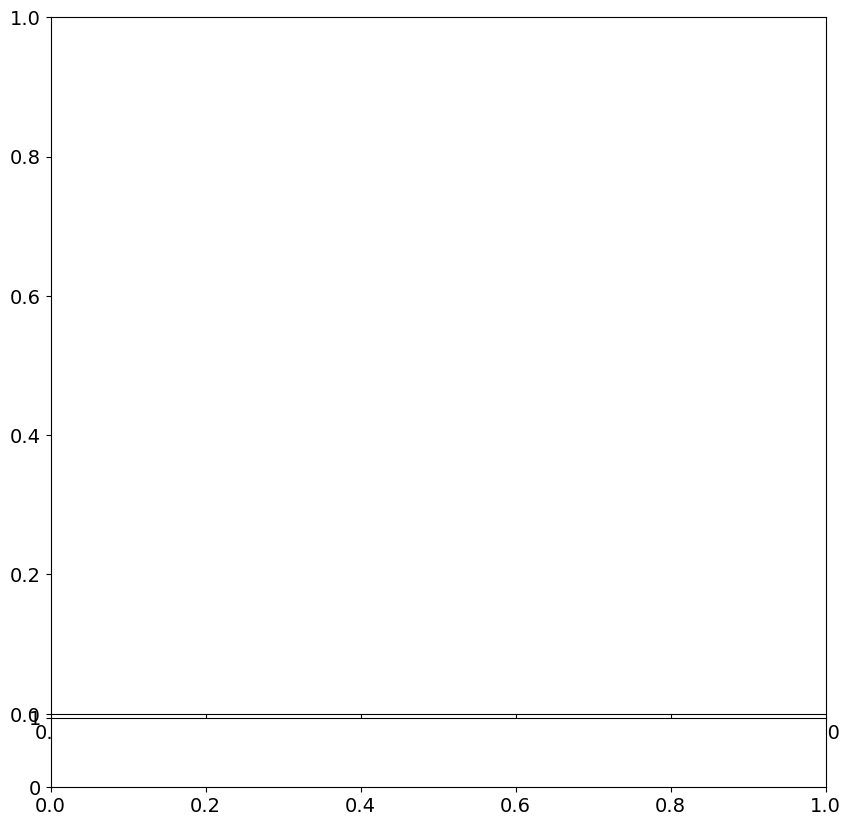

In [77]:
plt.rcParams.update({'font.size': 14})  # Define o tamanho global da fonte

for sta in tqdm(STATION_LST,total=len(STATION_LST),desc='Station'):
    df_sta = station_df[station_df['station'] == sta]

    YEAR_min = df_sta['year'].min()
    YEAR_max = df_sta['year'].max()

    years = np.arange(df_sta['year'].min(),df_sta['year'].max()+1,1)
   
    #Creating the figure
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 1,height_ratios=[10,1],hspace=0.01)

    # axis 1: orientation measurements
    ax1 = fig.add_subplot(gs[0])
    
    # axis 2: number of measurements
    ax2 = fig.add_subplot(gs[1],sharex=ax1)
    
    for idx,ye in enumerate(years):

        df_sta_year = df_sta[df_sta['year'] == int(ye)]

        if df_sta_year[df_sta_year['quality'] == 'good']['orient'].empty:
            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['orient'].values
            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values

            # statistics
            a = ax1.scatter([ye]*len(orientations_bad),orientations_bad,marker='.',c='gray',s=snr_bad*10,alpha=0.5,ec='k',label='bad')
            
            # Number of events
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'bad']['orient']), color='gray',width=0.2,alpha=0.5)
        else:

            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['orient'].values
            orientations_good = df_sta_year[df_sta_year['quality'] == 'good']['orient'].values
            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values
            snr_good = df_sta_year[df_sta_year['quality'] == 'good']['SNR'].abs().values

            mean_sta = round(circmean(orientations_good, high=360, low=-360),1)
            std_sta = round(circstd(np.radians(orientations_good)),2)

            # statistics
            a = ax1.scatter([ye]*len(orientations_bad),orientations_bad,marker='.',c='gray',s=snr_bad*10,alpha=0.5,ec='k',label='bad')
            b = ax1.scatter([ye]*len(orientations_good),orientations_good,marker='.',c='k',s=snr_good*10,alpha=0.75,ec='k',label='good')
            ax1.annotate(str(mean_sta)+'$\\pm$'+str(abs(std_sta))+'°', (ye, 95),fontsize=10, rotation=30,va='center',ha='center',bbox=dict(boxstyle="round", fc="white",ec='k',alpha=0.5))
            ax1.boxplot(orientations_good,positions=[ye],sym='',showmeans=False,widths=0.5,bootstrap=10000)
            
            # Number of events
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'bad']['orient']), color='gray',width=0.2,alpha=0.5)
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'good']['orient']), color='k',edgecolor='k',width=0.1)

    ax1.set_ylabel(r'Orientação($\theta$)')
    ax1.set_xlabel('Ano')
    ax1.set_ylim(-105,105)
    ax1.xaxis.set_major_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(20))
    ax1.yaxis.set_minor_locator(MultipleLocator(10))   
    ax1.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    ax1.grid(True)
    ax1.tick_params(axis="x", labelbottom=False, labeltop=False)
    ax1.set_title(sta,fontsize=20)
    ax1.legend(handles=[a,b])
    
    ax2.set_xticks(years)
    ax2.set_xticklabels(years, ha='right')
    ax2.xaxis.set_major_locator(MultipleLocator(1))
    ax2.yaxis.set_major_locator(MultipleLocator(25))
    ax2.yaxis.set_minor_locator(MultipleLocator(5))
    ax2.set_ylim(0,50)
    ax2.set_ylabel("n")
    ax2.grid(True)

    output_figure_ORIENTATION = ORIENTATION_OUTPUT+'ORIENTATION_FIGURES/FINAL_RESULT/'
    os.makedirs(output_figure_ORIENTATION,exist_ok=True)
    fig.savefig(output_figure_ORIENTATION+'ORIENTATION_TOTAL_'+sta+'.png',dpi=300)
    plt.close()

In [79]:
plt.rcParams.update({'font.size': 14})  # Define o tamanho global da fonte

for sta in tqdm(STATION_LST,total=len(STATION_LST),desc='Station'):
    df_sta = station_df[station_df['station'] == sta]

    YEAR_min = df_sta['year'].min()
    YEAR_max = df_sta['year'].max()

    years = np.arange(df_sta['year'].min(),df_sta['year'].max()+1,1)
   
    #Creating the figure
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 1,height_ratios=[10,1],hspace=0.01)

    # axis 1: orientation measurements
    ax1 = fig.add_subplot(gs[0])
    
    # axis 2: number of measurements
    ax2 = fig.add_subplot(gs[1],sharex=ax1)
    
    for idx,ye in enumerate(years):

        df_sta_year = df_sta[df_sta['year'] == int(ye)]

        if df_sta_year[df_sta_year['quality'] == 'good']['theta'].empty:
            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['theta'].values
            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values

            # statistics
            a = ax1.scatter([ye]*len(orientations_bad),orientations_bad,marker='.',c='gray',s=snr_bad*10,alpha=0.5,ec='k',label='bad')
            
            # Number of events
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'bad']['theta']), color='gray',width=0.2,alpha=0.5)
        else:

            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['theta'].values
            orientations_good = df_sta_year[df_sta_year['quality'] == 'good']['theta'].values
            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values
            snr_good = df_sta_year[df_sta_year['quality'] == 'good']['SNR'].abs().values

            mean_sta = round(circmean(orientations_good, high=360, low=-360),1)
            std_sta = round(circstd(np.radians(orientations_good)),2)

            # statistics
            a = ax1.scatter([ye]*len(orientations_bad),orientations_bad,marker='.',c='gray',s=snr_bad*10,alpha=0.5,ec='k',label='bad')
            b = ax1.scatter([ye]*len(orientations_good),orientations_good,marker='.',c='k',s=snr_good*10,alpha=0.75,ec='k',label='good')
            ax1.annotate(str(mean_sta)+'$\\pm$'+str(abs(std_sta))+'°', (ye, 95),fontsize=10, rotation=30,va='center',ha='center',bbox=dict(boxstyle="round", fc="white",ec='k',alpha=0.5))
            ax1.boxplot(orientations_good,positions=[ye],sym='',showmeans=False,widths=0.5,bootstrap=10000)
            
            # Number of events
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'bad']['theta']), color='gray',width=0.2,alpha=0.5)
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'good']['theta']), color='k',edgecolor='k',width=0.1)

    ax1.set_ylabel(r'Orientation($\theta$)')
    ax1.set_xlabel('Year')
    ax1.set_ylim(-180,180)
    ax1.xaxis.set_major_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(20))
    ax1.yaxis.set_minor_locator(MultipleLocator(10))   
    ax1.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    ax1.grid(True)
    ax1.tick_params(axis="x", labelbottom=False, labeltop=True)
    ax1.set_title(sta,fontsize=20)
    ax1.legend(handles=[a,b])
    
    ax2.set_xticks(years)
    ax2.set_xticklabels(years, ha='right')
    ax2.xaxis.set_major_locator(MultipleLocator(1))
    ax2.yaxis.set_major_locator(MultipleLocator(50))
    ax2.set_ylim(0,150)
    ax2.set_ylabel("n")
    ax2.grid(True)

    output_figure_ORIENTATION = ORIENTATION_OUTPUT+'ORIENTATION_FIGURES/FINAL_RESULT/'
    os.makedirs(output_figure_ORIENTATION,exist_ok=True)
    fig.savefig(output_figure_ORIENTATION+'ORIENTATION_TOTAL_'+sta+'.png',dpi=300)
    plt.close()

Station: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


In [80]:
station_df.columns

Index(['network', 'station', 'stla', 'stlo', 'evname', 'evla', 'evlo',
       'evtime', 'evmag', 'evtype', 'evdp', 'distance', 'gcarc', 'baz',
       'tr1_data', 'tr2_data', 'trZ_data', 'trZ_time', 'SS_best',
       'signal_strength', 'SZR_best', 'similarity_vertical_radial',
       'ERTR_best', 'energy_transverse_radial', 'ERRZ_best',
       'energy_radial_vertical', 'SNR', 'phi', 'theta', 'aic_curve',
       'clock_error', 'quality', 'year'],
      dtype='object')

In [83]:
plt.rcParams.update({'font.size': 14})  # Define o tamanho global da fonte

for sta in tqdm(STATION_LST,total=len(STATION_LST),desc='Station'):
    df_sta = station_df[station_df['station'] == sta]

    YEAR_min = df_sta['year'].min()
    YEAR_max = df_sta['year'].max()

    years = np.arange(df_sta['year'].min(),df_sta['year'].max()+1,1)
   
    #Creating the figure
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 1,height_ratios=[10,1],hspace=0.01)

    # axis 1: orientation measurements
    ax1 = fig.add_subplot(gs[0])
    
    # axis 2: number of measurements
    ax2 = fig.add_subplot(gs[1],sharex=ax1)
    
    for idx,ye in enumerate(years):

        df_sta_year = df_sta[df_sta['year'] == int(ye)]

        if df_sta_year[df_sta_year['quality'] == 'good']['theta'].empty:
            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['clock_error'].values
            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values

            # statistics
            a = ax1.scatter([ye]*len(orientations_bad),orientations_bad,marker='.',c='gray',s=snr_bad*10,alpha=0.5,ec='k',label='bad')
            
            # Number of events
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'bad']['theta']), color='gray',width=0.2,alpha=0.5)
        else:

            orientations_bad = df_sta_year[df_sta_year['quality'] == 'bad']['clock_error'].values
            orientations_good = df_sta_year[df_sta_year['quality'] == 'good']['clock_error'].values
            snr_bad = df_sta_year[df_sta_year['quality'] == 'bad']['SNR'].abs().values
            snr_good = df_sta_year[df_sta_year['quality'] == 'good']['SNR'].abs().values

            mean_sta = round(np.mean(orientations_good),1)
            std_sta = round(np.std(orientations_good),2)

            # statistics
            a = ax1.scatter([ye]*len(orientations_bad),orientations_bad,marker='.',c='gray',s=snr_bad*10,alpha=0.5,ec='k',label='bad')
            b = ax1.scatter([ye]*len(orientations_good),orientations_good,marker='.',c='k',s=snr_good*10,alpha=0.75,ec='k',label='good')
            ax1.annotate(str(mean_sta)+'$\\pm$'+str(abs(std_sta))+'°', (ye, 95),fontsize=10, rotation=30,va='center',ha='center',bbox=dict(boxstyle="round", fc="white",ec='k',alpha=0.5))
            ax1.boxplot(orientations_good,positions=[ye],sym='',showmeans=False,widths=0.5,bootstrap=10000)
            
            # Number of events
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'bad']['theta']), color='gray',width=0.2,alpha=0.5)
            ax2.bar(ye, len(df_sta_year[df_sta_year['quality'] == 'good']['theta']), color='k',edgecolor='k',width=0.1)

    ax1.set_ylabel('Clock error (s)')
    ax1.set_xlabel('Year')
    #ax1.set_ylim(-180,180)
    ax1.xaxis.set_major_locator(MultipleLocator(1))
    #ax1.yaxis.set_major_locator(MultipleLocator(20))
    #ax1.yaxis.set_minor_locator(MultipleLocator(10))   
    #ax1.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    ax1.grid(True)
    ax1.tick_params(axis="x", labelbottom=False, labeltop=True)
    ax1.set_title(sta,fontsize=20)
    ax1.legend(handles=[a,b])
    
    ax2.set_xticks(years)
    ax2.set_xticklabels(years, ha='right')
    ax2.xaxis.set_major_locator(MultipleLocator(1))
    ax2.yaxis.set_major_locator(MultipleLocator(50))
    ax2.set_ylim(0,150)
    ax2.set_ylabel("n")
    ax2.grid(True)

    output_figure_ORIENTATION = ORIENTATION_OUTPUT+'TIMING_FIGURES/FINAL_RESULT/'
    os.makedirs(output_figure_ORIENTATION,exist_ok=True)
    fig.savefig(output_figure_ORIENTATION+'TIMING_TOTAL_'+sta+'.png',dpi=300)
    plt.close()

Station: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


In [23]:
# Lista de markers que aceitam edgecolor='k'
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H']

# Lista de cores (você pode personalizar essas cores)
colors = plt.get_cmap('Accent').colors  # Paleta 'tab20' do Matplotlib

# Define o tamanho desejado
tamanho = len(STATION_LST)

# Gera a lista de markers e cores com repetição se necessário
marker_list = [markers[i % len(markers)] for i in range(tamanho)]
color_list = [colors[i % len(colors)] for i in range(tamanho)]

Station:   0%|                                            | 0/1 [00:00<?, ?it/s]


KeyError: 'orient'

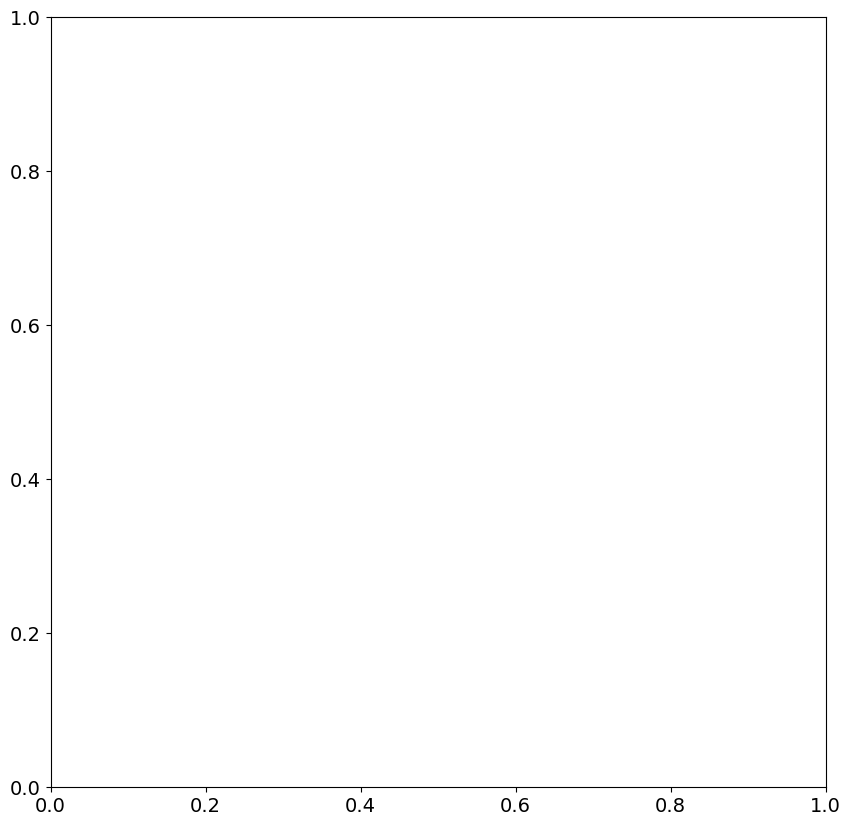

In [43]:
plt.rcParams.update({'font.size': 14})  # Define o tamanho global da fonte

# Criando a figura
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 1)
years = np.arange(2013, 2026, 1)

# Eixo 1: Medidas de orientação
ax1 = fig.add_subplot(gs[0])

for ista, sta in enumerate(tqdm(STATION_LST, total=len(STATION_LST), desc='Station')):
    df_sta = station_df[station_df['station'] == sta]

    YEAR_min = min(years)
    YEAR_max = max(years)

    # Flag para adicionar a legenda apenas no primeiro ponto de cada estação
    added_legend = False

    for idx, ye in enumerate(years):
        df_sta_year = df_sta[df_sta['year'] == int(ye)]

        if not df_sta_year[df_sta_year['quality'] == 'good']['orient'].empty:
            orientations_good = df_sta_year[df_sta_year['quality'] == 'good']['orient'].values
            snr_good = df_sta_year[df_sta_year['quality'] == 'good']['SNR'].abs().values

            # Plota com a legenda apenas no primeiro ponto
            ax1.scatter(
                ye, round(circmean(orientations_good, high=360, low=-360),1),
                marker=marker_list[ista], c=color_list[ista],
                s=snr_good.mean() * 10, alpha=0.5,ec='k',
                label=sta if not added_legend else None
            )
            added_legend = True  # Marca que a legenda foi adicionada

# Configurações do eixo
ax1.set_ylabel(r'Orientation($\theta$)')
ax1.set_xlabel('Year')
ax1.set_ylim(-180, 180)
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(40))
ax1.yaxis.set_minor_locator(MultipleLocator(10))
ax1.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax1.grid(True)
ax1.tick_params(axis="both", labelbottom=True, labelright=True, labelleft=True, labeltop=True)
ax1.legend(loc='lower right',ncol=int(len(STATION_LST)/4))
ax1.set_title('Orientation Compilation', fontsize=20)

# Salvando a figura
output_figure_ORIENTATION = ORIENTATION_OUTPUT + 'ORIENTATION_FIGURES/FINAL_RESULT/'
os.makedirs(output_figure_ORIENTATION, exist_ok=True)
fig.savefig(output_figure_ORIENTATION + 'ORIENTATION_TOTAL_COMPILATION.png', dpi=300)
plt.close()


In [49]:
plt.rcParams.update({'font.size': 15})  # Define o tamanho global da fonte

# Criando a figura
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(1, 1)
years = np.arange(2013, 2026, 1)

# Eixo 1: Medidas de orientação
ax1 = fig.add_subplot(gs[0])
ax1.axhline(y=0, xmin=0, xmax=1,c='k',ls=':',zorder=-10)

for ista, sta in enumerate(tqdm(STATION_LST, total=len(STATION_LST), desc='Station')):
    df_sta = station_df[station_df['station'] == sta]

    YEAR_min = min(years)
    YEAR_max = max(years)

    # Flag para adicionar a legenda apenas no primeiro ponto de cada estação
    added_legend = False

    for idx, ye in enumerate(years):
        df_sta_year = df_sta[df_sta['year'] == int(ye)]

        if not df_sta_year[df_sta_year['quality'] == 'good']['orient'].empty:
            orientations_good = df_sta_year[df_sta_year['quality'] == 'good']['orient'].values
            snr_good = df_sta_year[df_sta_year['quality'] == 'good']['SNR'].abs().values

            # Plota com a legenda apenas no primeiro ponto
            ax1.scatter(
                ye, round(circmean(orientations_good, high=360, low=-360),1),
                marker=marker_list[ista], c=color_list[ista],
                s=snr_good.mean() * 10, alpha=0.75,ec='k',linewidths=2,
                label=sta if not added_legend else None
            )


            added_legend = True  # Marca que a legenda foi adicionada

# Configurações do eixo
ax1.set_ylabel(r'Orientação ($\theta$)',fontsize=20)
ax1.set_xlabel('Ano',fontsize=20)
ax1.set_ylim(-180, 180)
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(40))
ax1.yaxis.set_minor_locator(MultipleLocator(10))
ax1.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax1.grid(which='major',linestyle=':')
ax1.tick_params(axis="both", which='both',labelbottom=True, labelright=True, labelleft=True, labeltop=False,bottom=True, top=True, left=True, right=True)
ax1.legend(loc='lower right',ncol=int(len(STATION_LST)/4))
ax1.set_title('Rede RSIS: Avaliação das Orientações', y=1.05,fontsize=25, fontweight='bold')

# Salvando a figura
output_figure_ORIENTATION = ORIENTATION_OUTPUT + 'ORIENTATION_FIGURES/FINAL_RESULT/'
os.makedirs(output_figure_ORIENTATION, exist_ok=True)
fig.savefig(output_figure_ORIENTATION + 'ORIENTATION_TOTAL_COMPILATION.png', dpi=300)
plt.close()


Station:   0%|                                                                                | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_87520/3951481912.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(
Station: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 72.06it/s]
